In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression , Lasso , Ridge , ElasticNet
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error


### Data Preprocessing and EDA 📊

In [26]:
data_frame = pd.read_csv('/Users/Bingumalla Likith/Desktop/Projects/Gold_Price_Prediction/FINAL_USO.csv')
# Convert to normal data and time format 
Date = pd.to_datetime(data_frame['Date'])
data_frame['Date'] = Date
# Value to be predicted
target = data_frame['Adj Close']

In [27]:
corr_matrix = data_frame.corr()
filter = list(abs(corr_matrix['Adj Close']) > 0.7)
data_frame = data_frame.iloc[: , filter]
data = data_frame.drop(columns = ['Adj Close'])

<Axes: >

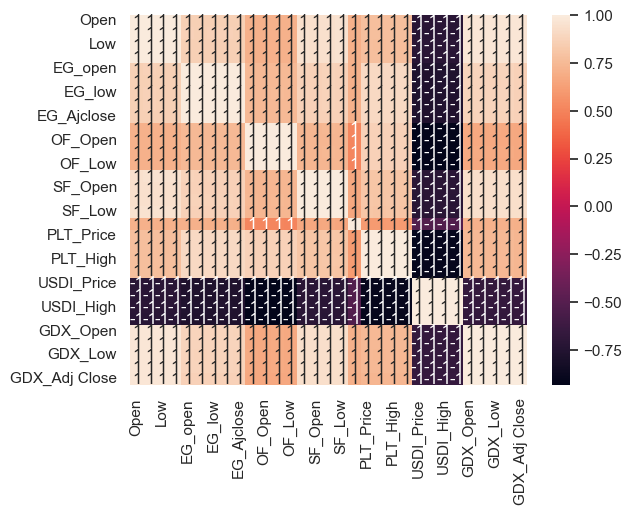

In [28]:
sns.heatmap(data.corr() , fmt = '.0f' , annot = True)

<Axes: >

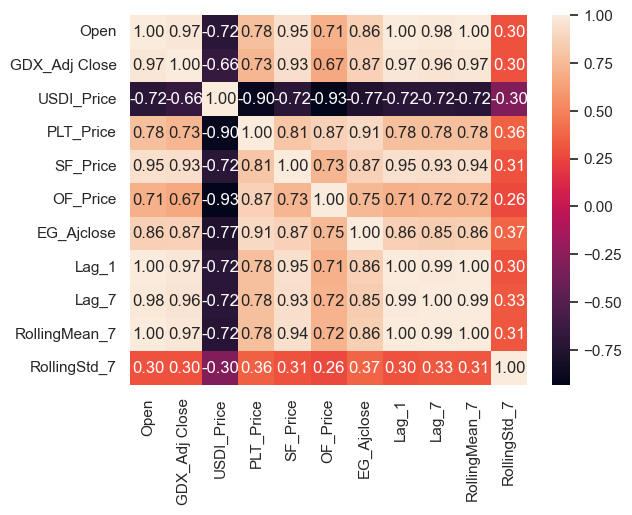

In [29]:
# On comparing and picking highly correlated features features
important_features = ['Open', 'GDX_Adj Close' , 'USDI_Price' , 'PLT_Price' , 'SF_Price' , 'OF_Price' , 'EG_Ajclose']
data = data[important_features]

# Necessary as most of the times current gold price depends on the previous data
# Create Lag Features
data['Lag_1'] = data['Open'].shift(1)
data['Lag_7'] = data['Open'].shift(7)

# Create Rolling Statistics
data['RollingMean_7'] = data['Open'].rolling(window=7).mean()
data['RollingStd_7'] = data['Open'].rolling(window=7).std()

sns.heatmap(data.corr() , annot = True , fmt = '.2f')

In [30]:
# As Rolling Standard deviation has very low correlation and Lag_1 is performing similar to Lag_7 we can drop that feature
data.drop(columns = ['RollingStd_7' , 'Lag_1'] , inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1718 non-null   float64
 1   GDX_Adj Close  1718 non-null   float64
 2   USDI_Price     1718 non-null   float64
 3   PLT_Price      1718 non-null   float64
 4   SF_Price       1718 non-null   int64  
 5   OF_Price       1718 non-null   float64
 6   EG_Ajclose     1718 non-null   float64
 7   Lag_7          1711 non-null   float64
 8   RollingMean_7  1712 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 120.9 KB


In [31]:
data.fillna(data.mean() , inplace = True) 

In [32]:
def distributions(data):
    fig , axes = plt.subplots(2, 4, figsize=(20, 10))
    plt.suptitle("Distributions")
    for i, column in enumerate(data.columns):
        sns.histplot(x = data[column] , ax = axes[(i // 4) - 1][i % 4] , kde = True)

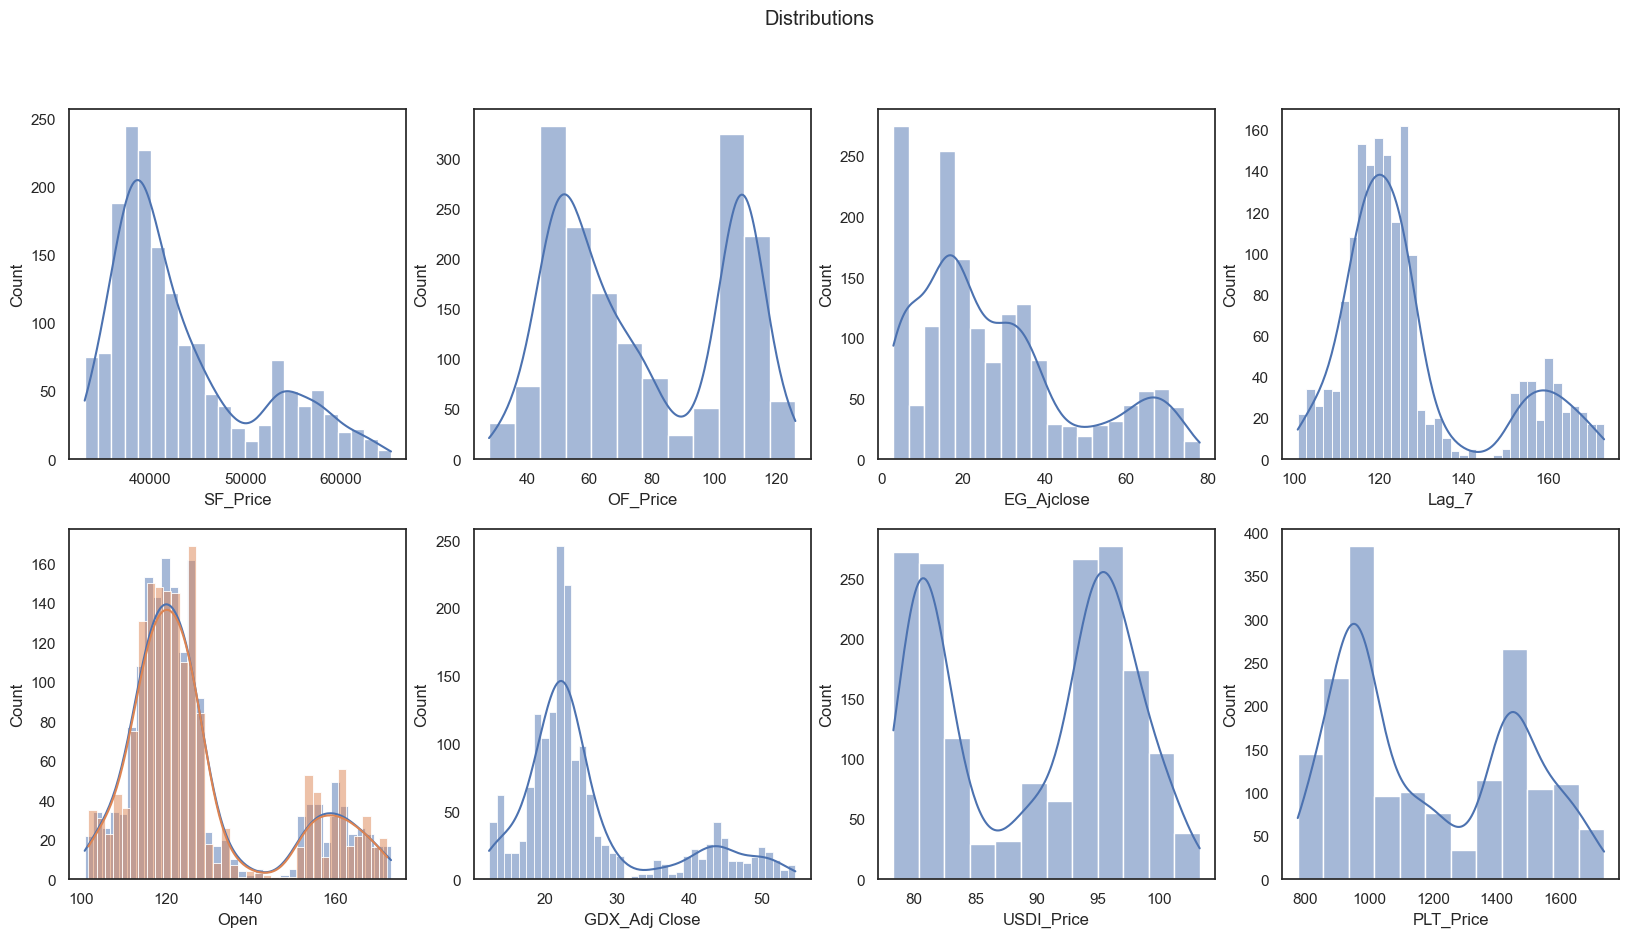

In [33]:
distributions(data) # There isnt much skewness in the data except few columns ['OF_PRICE' , 'EG_AJCLOSE' , 'USDI_PRICE']

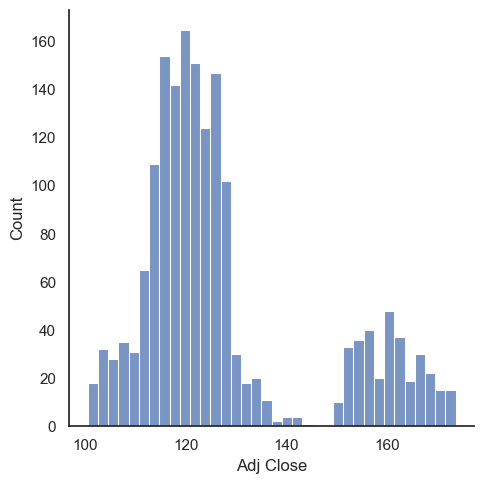

In [34]:
sns.displot(target)# Bimodal Skewness 

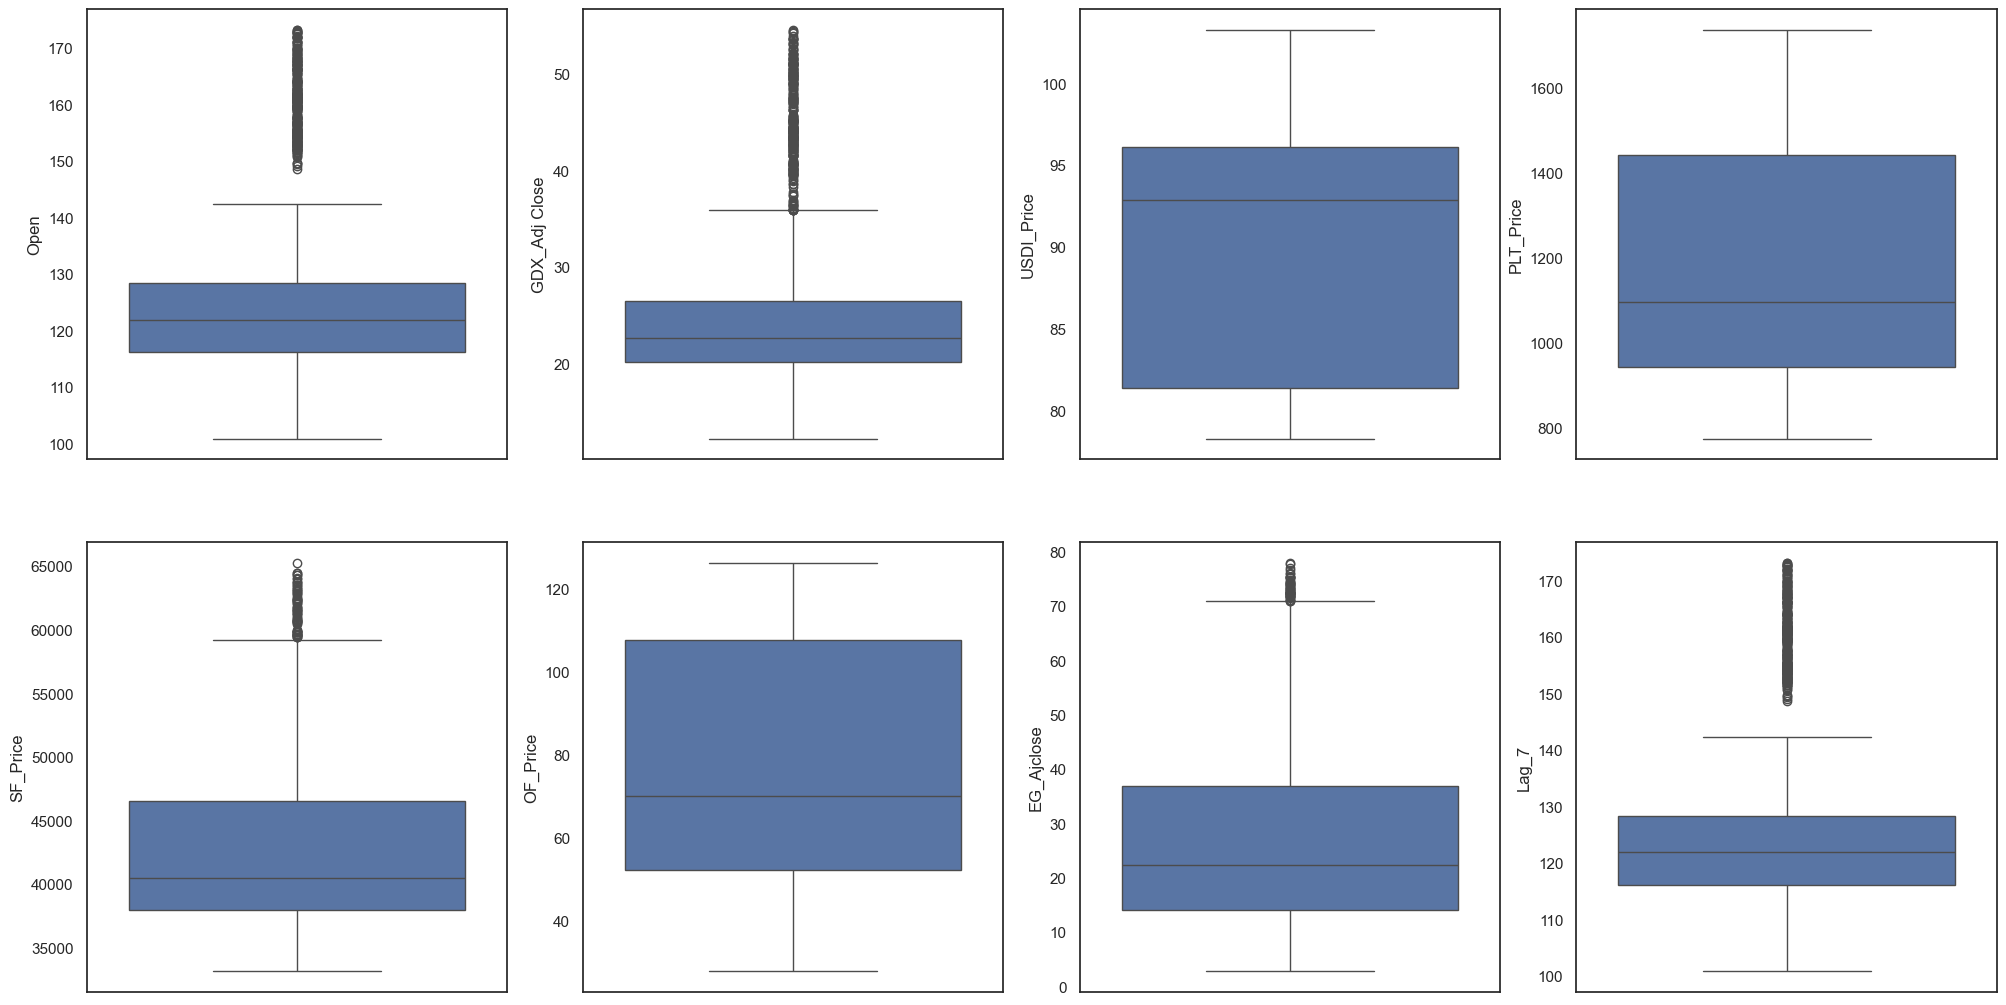

In [35]:
# Checking for outliers in the data
def Display_outliers(data):
    _ , axes = plt.subplots(nrows = 2 , ncols = 4, figsize = (20 , 10))
    axes = axes.flatten()
    columns = data.columns
    for index in range(8):
        sns.set_theme(style=  "white", font_scale=1)
        sns.boxplot(y = columns[index], data = data , ax = axes[index])
    plt.tight_layout(pad = 0.4 , w_pad=0.5 , h_pad=5.0)

Display_outliers(data)

In [36]:
target = target[data['GDX_Adj Close'] < 40]
Date = Date[data['GDX_Adj Close'] < 40]
data = data[data['GDX_Adj Close'] < 40]
data.reset_index(inplace = True)
data.drop(columns='index' , inplace = True)
# Removed outliers

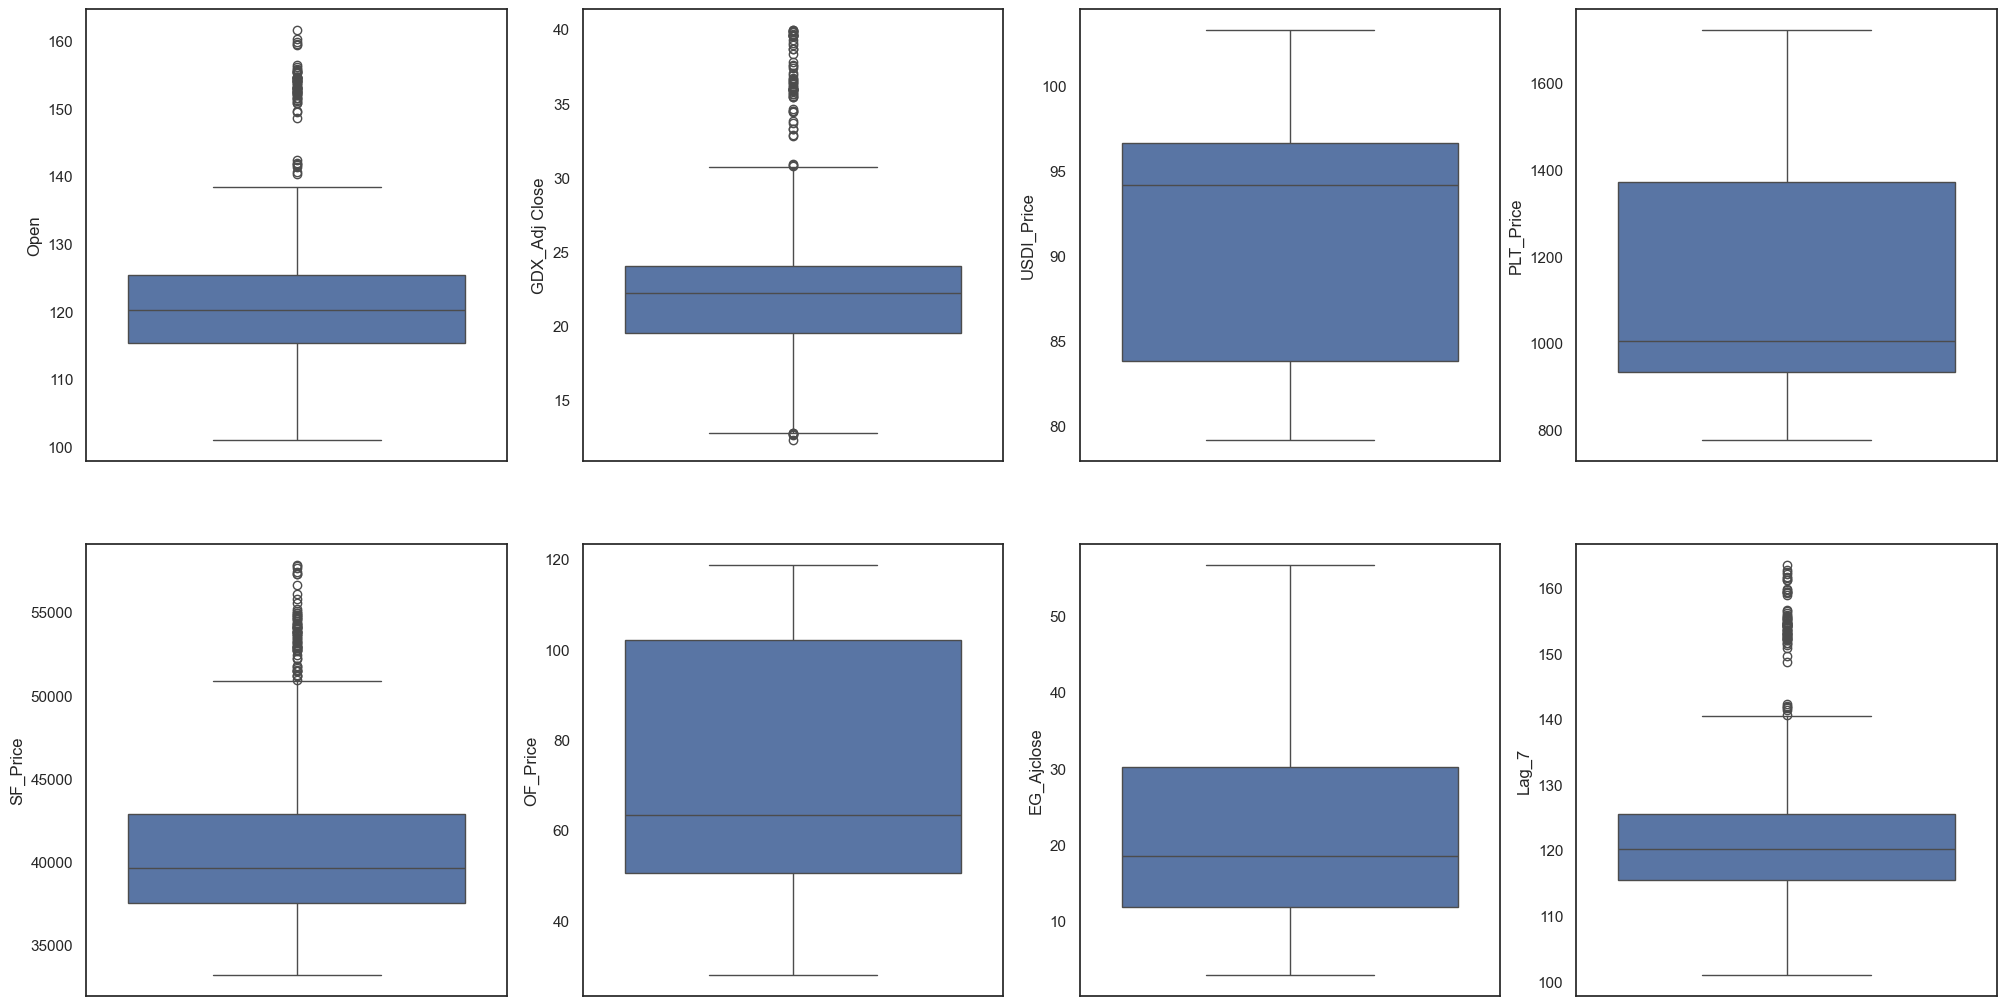

In [37]:
Display_outliers(data)

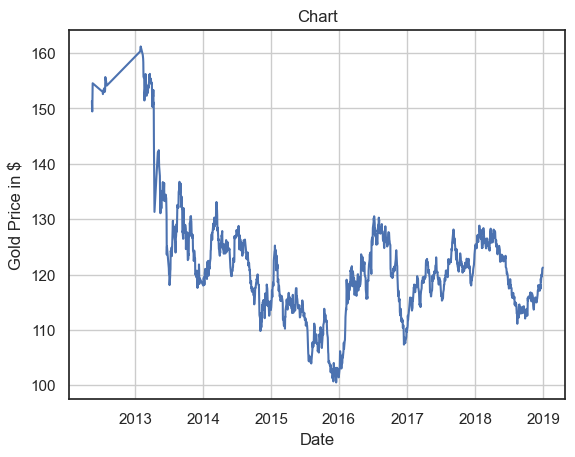

In [38]:
plt.plot(Date , target)
plt.xlabel('Date')
plt.ylabel('Gold Price in $')
plt.title('Chart')
plt.grid('on')

### Model Training and Testing 📈

In [39]:
x_train , x_test , y_train , y_test = train_test_split(data , target , test_size = 0.2 , random_state=42)

In [40]:
models = {'rigde' : Ridge() , 
          'lasso' : Lasso() ,
          'Elastic' : ElasticNet() , 
          'xg_boost' : XGBRegressor() , 
          'lin_reg' : LinearRegression() , 
          'd-trees' : DecisionTreeRegressor() , 
          'RFRegressor' : RandomForestRegressor() , 
          'GBRegressor' : GradientBoostingRegressor()}

for name , model in models.items():
    model.fit(x_train, y_train)
    train_predict = model.predict(x_train)
    print(f'the training error of {name} is : {mean_squared_error(train_predict , y_train)}')

the training error of rigde is : 0.43608862505422824
the training error of lasso is : 0.49552102139493687
the training error of Elastic is : 0.5373472327023672
the training error of xg_boost is : 0.006275739563584381
the training error of lin_reg is : 0.4360881685793487
the training error of d-trees is : 0.0
the training error of RFRegressor is : 0.07788064380494433
the training error of GBRegressor is : 0.21594220650761492


In [41]:
# On observing the performances we can pick 3 models : xg_boost , d-trees , RandomForestRegressor
algos = {
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [10, 50, 100, 130],
                'max_depth': range(2, 4, 1),
                'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],
                'max_features': ['sqrt', 'log2']
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [2, 3],
                'n_estimators': [10, 50, 100, 200]
            }
        }
}

final_models = []
for algorithm_name , config in algos.items():
    gscv = GridSearchCV(config['model'] , config['params'] , cv = 5)
    gscv.fit(x_train , y_train)
    final_models.append({'name' : algorithm_name ,'model' : gscv.best_estimator_ , 'score' : gscv.best_score_})

In [42]:
for item in final_models:
    print(f"{item['name']} : {item['score']}")
    
#XGBRegressor out-performed the other 2

decision_tree : 0.9895623313840579
RandomForestRegressor : 0.9736101640013848
XGBRegressor : 0.9933821987645366


In [43]:
model = final_models[2]['model']

In [44]:
# Let's test the model over test data
y_pred = model.predict(x_test)

print(f'R2-Score : {r2_score(y_pred , y_test)}')
print(f'mean_absolute_error : {mean_absolute_error(y_pred , y_test)}')
print(f'mean_squared_error : {mean_squared_error(y_pred , y_test)}')

R2-Score : 0.9929367473453464
mean_absolute_error : 0.5160165409954899
mean_squared_error : 0.6851082456657362


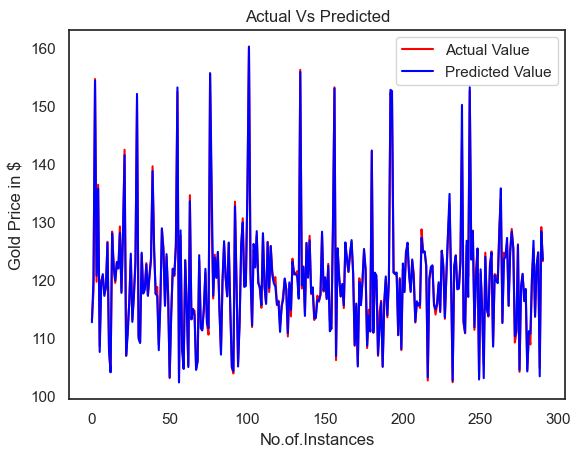

In [45]:
plt.plot(list(y_test) , color = 'red' , label = 'Actual Value')
plt.plot(list(y_pred) , color = 'blue' , label = 'Predicted Value')
plt.title('Actual Vs Predicted')
plt.ylabel('Gold Price in $')
plt.xlabel('No.of.Instances')
plt.legend()
plt.show()

In [46]:
# Now lets check over the main data
def Comparision(data , target , model):
    new_data = data[500:]
    old_target = list(target[:500])

    plt.figure(figsize=(20 , 5))
    plt.subplot(1 , 2 , 1)
    plt.plot(list(target) , color = 'blue' , label = 'original')
    plt.legend()
    plt.ylabel('Gold Price in $')
    plt.title('Original')

    
    plt.subplot(1 , 2,  2)
    y_pred = model.predict(new_data)
    plt.plot(range(0 , 500) , old_target , color = 'blue' , label = 'original')
    plt.plot(range(500 , len(list(target))) , y_pred , color = 'red' , label = 'predicted')
    plt.legend()
    plt.ylabel('Gold Price in $')
    plt.title('Models Prediction')

    plt.suptitle('Results Comparisions')

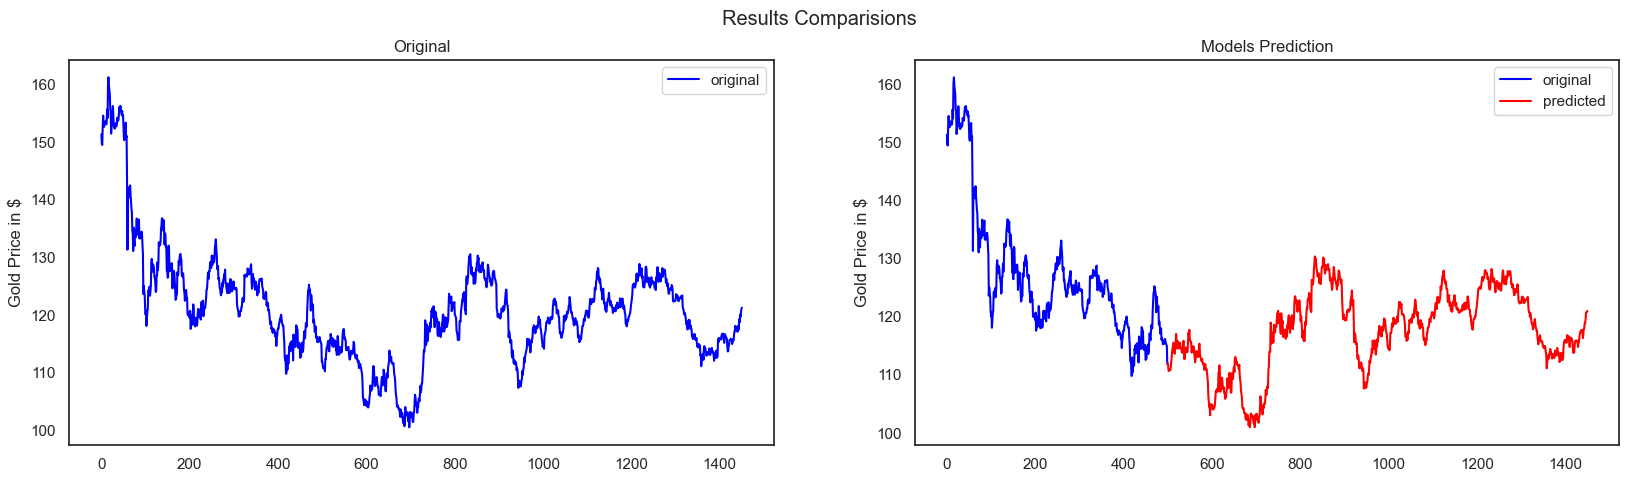

In [47]:
Comparision(data , target , model) # Comparision over last 500 instances